In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, psutil
import time
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,  confusion_matrix,classification_report
from catboost import CatBoostClassifier

df = pd.read_csv(r'C:\Users\HP\Desktop\Oreilly\Blue Team\IoT\Edge-IIoTset dataset\Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv', low_memory=False)

In [2]:
df.head()

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


In [3]:
print(df['Attack_type'].value_counts())

Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: Attack_type, dtype: int64


In [4]:
from sklearn.utils import shuffle

drop_columns = ["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","arp.dst.proto_ipv4", 

         "http.file_data","http.request.full_uri","icmp.transmit_timestamp",

         "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

         "tcp.dstport", "udp.port", "mqtt.msg"]

df.drop(drop_columns, axis=1, inplace=True)

df.dropna(axis=0, how='any', inplace=True)

df.drop_duplicates(subset=None, keep="first", inplace=True)

df = shuffle(df)

df.isna().sum()

print(df['Attack_type'].value_counts())

Normal                   24101
DDoS_UDP                 14498
DDoS_ICMP                13096
DDoS_HTTP                10495
SQL_injection            10282
DDoS_TCP                 10247
Uploading                10214
Vulnerability_scanner    10062
Password                  9972
Backdoor                  9865
Ransomware                9689
XSS                       9543
Port_Scanning             8921
Fingerprinting             853
MITM                       358
Name: Attack_type, dtype: int64


In [5]:
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing

def encode_text_dummy(df, name):

    dummies = pd.get_dummies(df[name])

    for x in dummies.columns:

        dummy_name = f"{name}-{x}"

        df[dummy_name] = dummies[x]

    df.drop(name, axis=1, inplace=True)

encode_text_dummy(df,'http.request.method')

encode_text_dummy(df,'http.referer')

encode_text_dummy(df,"http.request.version")

encode_text_dummy(df,"dns.qry.name.len")

encode_text_dummy(df,"mqtt.conack.flags")

encode_text_dummy(df,"mqtt.protoname")

encode_text_dummy(df,"mqtt.topic")

In [6]:
%%time
# taken from https://www.kaggle.com/ryanholbrook/getting-started-september-2021-tabular-playground

def cpu_stats():
    pid = os.getpid()
    py = psutil.Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return 'memory GB:' + str(np.round(memory_use, 2))

def score(X, y, model, cv):
    scoring = ["roc_auc"]
    scores = cross_validate(
        model, X_train, y_train, scoring=scoring, cv=cv, return_train_score=True
    )
    scores = pd.DataFrame(scores).T
    return scores.assign(
        mean = lambda x: x.mean(axis=1),
        std = lambda x: x.std(axis=1),
    )

Wall time: 0 ns


In [7]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
import os, psutil
import numpy as np
df = reduce_memory_usage(df, verbose=True)
print(cpu_stats())
print('Memory reduced')

Mem. usage decreased to 21.48 Mb (60.1% reduction)
memory GB:0.31
Memory reduced


In [9]:
df.head()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,tcp.ack_raw,...,dns.qry.name.len-_googlecast._tcp.local,mqtt.conack.flags-0,mqtt.conack.flags-0.0,mqtt.conack.flags-0x00000000,mqtt.protoname-0,mqtt.protoname-0.0,mqtt.protoname-MQTT,mqtt.topic-0,mqtt.topic-0.0,mqtt.topic-Temperature_and_Humidity
69076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,582356032.0,5.823560e+08,...,0,0,1,0,0,1,0,0,1,0
130059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0,0,1,0,0,1,0,0,1,0
69344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.854535e+08,...,0,0,1,0,0,1,0,0,1,0
94705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2386353.0,2.694442e+09,...,0,0,1,0,0,1,0,0,1,0
156773,0.0,0.0,43721.0,12038.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0,0,1,0,0,1,0,0,1,0


In [10]:
df = df.loc[(df['Attack_type'] == "Normal") | (df['Attack_type'] == "SQL_injection") | (df['Attack_type'] == "Uploading") | (df['Attack_type'] == "XSS")]

In [11]:
print(df['Attack_type'].value_counts())

Normal           24101
SQL_injection    10282
Uploading        10214
XSS               9543
Name: Attack_type, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Attack_type'] = le.fit_transform(df['Attack_type'])

In [13]:
features = [c for c in df.columns if c not in ("Attack_type")]

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for col in features:
    df[col] = scaler.fit_transform(np.array(df[col]).reshape(-1,1))

In [15]:
X = df.drop('Attack_type',axis=1)
y = df['Attack_type']

x_train,x_test,y_train,y_true = train_test_split(X,y,test_size = 0.3, random_state=42, shuffle=True)

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Reds):

     plt.imshow(cm, interpolation='nearest', cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)

     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
     else:
         print('Confusion matrix, without normalization')

     print(cm)

     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

     plt.tight_layout()
     plt.ylabel('Predicted label')
     plt.xlabel('Actual label')

In [17]:
model = CatBoostClassifier()

start = time.time()

model.fit(x_train, y_train)

end = time.time()
time_complexity_cat = end - start

Learning rate set to 0.095243
0:	learn: 1.1489218	total: 222ms	remaining: 3m 41s
1:	learn: 0.9820344	total: 278ms	remaining: 2m 18s
2:	learn: 0.8574070	total: 335ms	remaining: 1m 51s
3:	learn: 0.7560576	total: 377ms	remaining: 1m 33s
4:	learn: 0.6734496	total: 456ms	remaining: 1m 30s
5:	learn: 0.6036200	total: 503ms	remaining: 1m 23s
6:	learn: 0.5440367	total: 539ms	remaining: 1m 16s
7:	learn: 0.4935827	total: 578ms	remaining: 1m 11s
8:	learn: 0.4506167	total: 626ms	remaining: 1m 8s
9:	learn: 0.4121428	total: 668ms	remaining: 1m 6s
10:	learn: 0.3784831	total: 702ms	remaining: 1m 3s
11:	learn: 0.3492734	total: 739ms	remaining: 1m
12:	learn: 0.3235453	total: 770ms	remaining: 58.5s
13:	learn: 0.2996236	total: 804ms	remaining: 56.6s
14:	learn: 0.2780739	total: 839ms	remaining: 55.1s
15:	learn: 0.2591323	total: 870ms	remaining: 53.5s
16:	learn: 0.2421970	total: 920ms	remaining: 53.2s
17:	learn: 0.2270610	total: 948ms	remaining: 51.7s
18:	learn: 0.2134379	total: 977ms	remaining: 50.4s
19:	le

160:	learn: 0.0723954	total: 7.31s	remaining: 38.1s
161:	learn: 0.0723326	total: 7.36s	remaining: 38s
162:	learn: 0.0723195	total: 7.41s	remaining: 38s
163:	learn: 0.0722238	total: 7.45s	remaining: 38s
164:	learn: 0.0722205	total: 7.49s	remaining: 37.9s
165:	learn: 0.0722096	total: 7.54s	remaining: 37.9s
166:	learn: 0.0721907	total: 7.59s	remaining: 37.9s
167:	learn: 0.0721702	total: 7.63s	remaining: 37.8s
168:	learn: 0.0721387	total: 7.7s	remaining: 37.8s
169:	learn: 0.0721273	total: 7.74s	remaining: 37.8s
170:	learn: 0.0720958	total: 7.78s	remaining: 37.7s
171:	learn: 0.0720711	total: 7.82s	remaining: 37.6s
172:	learn: 0.0720646	total: 7.86s	remaining: 37.6s
173:	learn: 0.0720414	total: 7.9s	remaining: 37.5s
174:	learn: 0.0720176	total: 7.94s	remaining: 37.4s
175:	learn: 0.0720018	total: 7.98s	remaining: 37.3s
176:	learn: 0.0719920	total: 8.02s	remaining: 37.3s
177:	learn: 0.0719739	total: 8.05s	remaining: 37.2s
178:	learn: 0.0719671	total: 8.08s	remaining: 37.1s
179:	learn: 0.071883

319:	learn: 0.0696648	total: 13.7s	remaining: 29.1s
320:	learn: 0.0696640	total: 13.7s	remaining: 29s
321:	learn: 0.0696608	total: 13.8s	remaining: 29s
322:	learn: 0.0696474	total: 13.8s	remaining: 28.9s
323:	learn: 0.0696347	total: 13.8s	remaining: 28.9s
324:	learn: 0.0696314	total: 13.9s	remaining: 28.8s
325:	learn: 0.0696298	total: 13.9s	remaining: 28.8s
326:	learn: 0.0696181	total: 14s	remaining: 28.7s
327:	learn: 0.0696110	total: 14s	remaining: 28.7s
328:	learn: 0.0696081	total: 14s	remaining: 28.6s
329:	learn: 0.0696057	total: 14.1s	remaining: 28.5s
330:	learn: 0.0695995	total: 14.1s	remaining: 28.5s
331:	learn: 0.0695936	total: 14.1s	remaining: 28.4s
332:	learn: 0.0695711	total: 14.1s	remaining: 28.3s
333:	learn: 0.0695622	total: 14.2s	remaining: 28.2s
334:	learn: 0.0695580	total: 14.2s	remaining: 28.2s
335:	learn: 0.0695559	total: 14.2s	remaining: 28.1s
336:	learn: 0.0695445	total: 14.2s	remaining: 28s
337:	learn: 0.0695416	total: 14.2s	remaining: 27.9s
338:	learn: 0.0695382	to

478:	learn: 0.0682708	total: 19.5s	remaining: 21.2s
479:	learn: 0.0682619	total: 19.5s	remaining: 21.1s
480:	learn: 0.0682548	total: 19.5s	remaining: 21.1s
481:	learn: 0.0682523	total: 19.6s	remaining: 21s
482:	learn: 0.0682461	total: 19.6s	remaining: 21s
483:	learn: 0.0682393	total: 19.6s	remaining: 20.9s
484:	learn: 0.0682327	total: 19.6s	remaining: 20.9s
485:	learn: 0.0682179	total: 19.7s	remaining: 20.8s
486:	learn: 0.0682167	total: 19.7s	remaining: 20.8s
487:	learn: 0.0682108	total: 19.8s	remaining: 20.7s
488:	learn: 0.0682022	total: 19.8s	remaining: 20.7s
489:	learn: 0.0682005	total: 19.8s	remaining: 20.6s
490:	learn: 0.0681982	total: 19.9s	remaining: 20.6s
491:	learn: 0.0681925	total: 20s	remaining: 20.6s
492:	learn: 0.0681867	total: 20s	remaining: 20.6s
493:	learn: 0.0681829	total: 20s	remaining: 20.5s
494:	learn: 0.0681631	total: 20.1s	remaining: 20.5s
495:	learn: 0.0681596	total: 20.1s	remaining: 20.4s
496:	learn: 0.0681571	total: 20.2s	remaining: 20.4s
497:	learn: 0.0681505	

638:	learn: 0.0670480	total: 25.3s	remaining: 14.3s
639:	learn: 0.0670431	total: 25.3s	remaining: 14.2s
640:	learn: 0.0670275	total: 25.3s	remaining: 14.2s
641:	learn: 0.0670187	total: 25.4s	remaining: 14.1s
642:	learn: 0.0670132	total: 25.4s	remaining: 14.1s
643:	learn: 0.0670074	total: 25.5s	remaining: 14.1s
644:	learn: 0.0669976	total: 25.5s	remaining: 14s
645:	learn: 0.0669936	total: 25.5s	remaining: 14s
646:	learn: 0.0669867	total: 25.6s	remaining: 13.9s
647:	learn: 0.0669774	total: 25.6s	remaining: 13.9s
648:	learn: 0.0669695	total: 25.6s	remaining: 13.9s
649:	learn: 0.0669666	total: 25.7s	remaining: 13.8s
650:	learn: 0.0669592	total: 25.7s	remaining: 13.8s
651:	learn: 0.0669404	total: 25.7s	remaining: 13.7s
652:	learn: 0.0669335	total: 25.8s	remaining: 13.7s
653:	learn: 0.0669252	total: 25.8s	remaining: 13.7s
654:	learn: 0.0669192	total: 25.9s	remaining: 13.6s
655:	learn: 0.0669100	total: 25.9s	remaining: 13.6s
656:	learn: 0.0669066	total: 26s	remaining: 13.6s
657:	learn: 0.0669

798:	learn: 0.0661204	total: 31.3s	remaining: 7.88s
799:	learn: 0.0661170	total: 31.4s	remaining: 7.84s
800:	learn: 0.0661055	total: 31.4s	remaining: 7.8s
801:	learn: 0.0661027	total: 31.4s	remaining: 7.76s
802:	learn: 0.0661013	total: 31.5s	remaining: 7.72s
803:	learn: 0.0661001	total: 31.5s	remaining: 7.68s
804:	learn: 0.0660977	total: 31.5s	remaining: 7.64s
805:	learn: 0.0660962	total: 31.6s	remaining: 7.6s
806:	learn: 0.0660893	total: 31.6s	remaining: 7.56s
807:	learn: 0.0660833	total: 31.7s	remaining: 7.52s
808:	learn: 0.0660822	total: 31.7s	remaining: 7.49s
809:	learn: 0.0660740	total: 31.8s	remaining: 7.45s
810:	learn: 0.0660729	total: 31.9s	remaining: 7.44s
811:	learn: 0.0660700	total: 32s	remaining: 7.41s
812:	learn: 0.0660678	total: 32.1s	remaining: 7.38s
813:	learn: 0.0660665	total: 32.1s	remaining: 7.34s
814:	learn: 0.0660661	total: 32.1s	remaining: 7.29s
815:	learn: 0.0660629	total: 32.2s	remaining: 7.25s
816:	learn: 0.0660619	total: 32.2s	remaining: 7.21s
817:	learn: 0.06

959:	learn: 0.0654749	total: 38.5s	remaining: 1.61s
960:	learn: 0.0654699	total: 38.6s	remaining: 1.56s
961:	learn: 0.0654697	total: 38.6s	remaining: 1.52s
962:	learn: 0.0654693	total: 38.6s	remaining: 1.48s
963:	learn: 0.0654648	total: 38.7s	remaining: 1.44s
964:	learn: 0.0654640	total: 38.7s	remaining: 1.4s
965:	learn: 0.0654609	total: 38.7s	remaining: 1.36s
966:	learn: 0.0654543	total: 38.8s	remaining: 1.32s
967:	learn: 0.0654496	total: 38.8s	remaining: 1.28s
968:	learn: 0.0654440	total: 38.8s	remaining: 1.24s
969:	learn: 0.0654432	total: 38.8s	remaining: 1.2s
970:	learn: 0.0654371	total: 38.9s	remaining: 1.16s
971:	learn: 0.0654329	total: 38.9s	remaining: 1.12s
972:	learn: 0.0654326	total: 38.9s	remaining: 1.08s
973:	learn: 0.0654306	total: 39s	remaining: 1.04s
974:	learn: 0.0654257	total: 39s	remaining: 1s
975:	learn: 0.0654202	total: 39s	remaining: 960ms
976:	learn: 0.0654112	total: 39.1s	remaining: 920ms
977:	learn: 0.0654084	total: 39.1s	remaining: 880ms
978:	learn: 0.0654079	t

In [18]:
y_pred = model.predict(x_test)

In [19]:
print(y_pred)

[[3]
 [2]
 [3]
 ...
 [1]
 [0]
 [0]]


Confusion matrix, without normalization
[[7191    0    0    0]
 [   0 2750  347    0]
 [   0  276 2730    0]
 [   0    0    0 2948]]


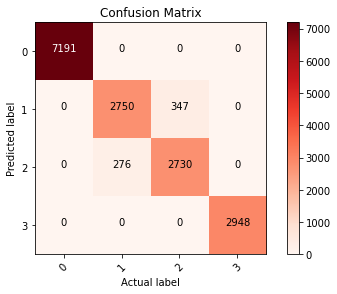

In [20]:
acc_score_cat = accuracy_score(y_true, y_pred,)
f1_score_cat = f1_score(y_true, y_pred,average='micro')
recall_score_cat = recall_score(y_true, y_pred,average='micro')
precision_score_cat = precision_score(y_true, y_pred,average='micro')

conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
conf_mat_plot_labels = ['0', '1','2','3']
plot_confusion_matrix(cm=conf_mat, classes=conf_mat_plot_labels, title='Confusion Matrix')